In [1]:
#importing required modules 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder,StandardScaler
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
import random
import os

from pyspark.sql import SparkSession 

In [2]:
# loading dataset 
spark = SparkSession.builder.appName("SparkSQL").getOrCreate()

23/06/08 19:04:45 WARN Utils: Your hostname, Johns-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 10.0.0.25 instead (on interface en0)
23/06/08 19:04:45 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/06/08 19:04:46 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
# load the dataset and create sprk dataframe

sql_df = spark.read.csv('../JC_Project_4_working/Loan_Train.csv', sep=",", inferSchema=True,header=True)

# Using limit(), or select() or show() to view the data. I often use limit()
# Using toPandas() method to return Pyspark DataFrame as Pandas table

sql_df.limit(5).toPandas()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360,1,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360,1,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360,1,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360,1,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360,1,Urban,Y


In [4]:
sql_df.show()

+--------+------+-------+----------+------------+-------------+---------------+-----------------+----------+----------------+--------------+-------------+-----------+
| Loan_ID|Gender|Married|Dependents|   Education|Self_Employed|ApplicantIncome|CoapplicantIncome|LoanAmount|Loan_Amount_Term|Credit_History|Property_Area|Loan_Status|
+--------+------+-------+----------+------------+-------------+---------------+-----------------+----------+----------------+--------------+-------------+-----------+
|LP001002|  Male|     No|         0|    Graduate|           No|           5849|              0.0|      null|             360|             1|        Urban|          Y|
|LP001003|  Male|    Yes|         1|    Graduate|           No|           4583|           1508.0|       128|             360|             1|        Rural|          N|
|LP001005|  Male|    Yes|         0|    Graduate|          Yes|           3000|              0.0|        66|             360|             1|        Urban|          Y

In [5]:
sql_df.printSchema()

root
 |-- Loan_ID: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Married: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- Education: string (nullable = true)
 |-- Self_Employed: string (nullable = true)
 |-- ApplicantIncome: integer (nullable = true)
 |-- CoapplicantIncome: double (nullable = true)
 |-- LoanAmount: integer (nullable = true)
 |-- Loan_Amount_Term: integer (nullable = true)
 |-- Credit_History: integer (nullable = true)
 |-- Property_Area: string (nullable = true)
 |-- Loan_Status: string (nullable = true)



***For visualization, converting PySpark Dataframe to Pandas DataFrame***

In [6]:
#from spark.sql df to Panadas df

data = sql_df.toPandas()

In [7]:
# Describing data
data.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


In [8]:
#check datatypes
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int32  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int32(1), object(8)
memory usage: 60.1+ KB


In [9]:
# filtering out outliers from ApplicantIncome and LoanAmount Column
# Calculate outliers for LoanAmount column
Q1_loan = data['LoanAmount'].quantile(0.25)
Q3_loan = data['LoanAmount'].quantile(0.75)
IQR_loan = Q3_loan - Q1_loan

lower_bound_loan = Q1_loan - (1.5 * IQR_loan)
upper_bound_loan = Q3_loan + (1.5 * IQR_loan)

# Filter outliers for LoanAmount column
outliers_loan = data[(data['LoanAmount'] < lower_bound_loan) | (data['LoanAmount'] > upper_bound_loan)]

# Calculate outliers for ApplicantIncome column
Q1_income = data['ApplicantIncome'].quantile(0.25)
Q3_income = data['ApplicantIncome'].quantile(0.75)
IQR_income = Q3_income - Q1_income

lower_bound_income = Q1_income - (1.5 * IQR_income)
upper_bound_income = Q3_income + (1.5 * IQR_income)

# Filter outliers for ApplicantIncome column
outliers_income = data[(data['ApplicantIncome'] < lower_bound_income) | (data['ApplicantIncome'] > upper_bound_income)]

# Create filtered DataFrame without outliers
filtered_data_df = data[~(data['LoanAmount'].isin(outliers_loan['LoanAmount']) | data['ApplicantIncome'].isin(outliers_income['ApplicantIncome']))]



In [10]:
filtered_data_df.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,547.000000,547.000000,527.000000,533.000000,502.000000
mean,4047.550274,1537.052870,127.396584,342.101313,0.840637
std,1855.553192,2380.417249,46.334010,65.971721,0.366379
min,150.000000,0.000000,9.000000,12.000000,0.000000
25%,2719.000000,0.000000,99.000000,360.000000,1.000000
50%,3597.000000,1330.000000,122.000000,360.000000,1.000000
75%,4906.000000,2264.500000,155.000000,360.000000,1.000000
max,10139.000000,33837.000000,267.000000,480.000000,1.000000


In [11]:
filtered_data_df['Loan_Status'].value_counts()

Y    379
N    168
Name: Loan_Status, dtype: int64

In [12]:
# Dropping Loan_ID column
filtered_data_df.drop(['Loan_ID'],axis=1,inplace=True)

/var/folders/yy/0dc43z0j4_x1wkm1104h5l800000gn/T/ipykernel_4041/3681671997.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data_df.drop(['Loan_ID'],axis=1,inplace=True)


## Filling NULL values 

In [13]:
#check null values
filtered_data_df.isnull().sum()

Gender                9
Married               3
Dependents           14
Education             0
Self_Employed        29
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           20
Loan_Amount_Term     14
Credit_History       45
Property_Area         0
Loan_Status           0
dtype: int64

In [14]:
# Check the number of null values in each row
null_rows = filtered_data_df.isnull().sum(axis=1)

# Count the number of rows with null values
num_null_rows = null_rows[null_rows > 0].count()

# Display the count
print("Number of rows with null values:", num_null_rows)

Number of rows with null values: 121


In [15]:
#filling null values-- filling in null values with mode or mean values of the data. So if gender has more male than female, then we will fill Null values with Male. 

filtered_data_df.Gender.fillna(filtered_data_df['Gender'].mode()[0], inplace=True)

filtered_data_df.Married.fillna(filtered_data_df['Married'].mode()[0], inplace=True)

filtered_data_df['Dependents'].fillna(filtered_data_df['Dependents'].mode()[0], inplace=True)


filtered_data_df.Self_Employed.fillna(filtered_data_df['Self_Employed'].mode()[0], inplace=True)

filtered_data_df['LoanAmount'].fillna(filtered_data_df['LoanAmount'].mean(), inplace=True) # Mean



filtered_data_df['Loan_Amount_Term'].fillna(filtered_data_df['Loan_Amount_Term'].mean(), inplace=True)

filtered_data_df['Credit_History'].fillna(filtered_data_df['Credit_History'].mode()[0], inplace=True) # Mode



/var/folders/yy/0dc43z0j4_x1wkm1104h5l800000gn/T/ipykernel_4041/717514777.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data_df.Gender.fillna(filtered_data_df['Gender'].mode()[0], inplace=True)
/var/folders/yy/0dc43z0j4_x1wkm1104h5l800000gn/T/ipykernel_4041/717514777.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data_df.Married.fillna(filtered_data_df['Married'].mode()[0], inplace=True)
/var/folders/yy/0dc43z0j4_x1wkm1104h5l800000gn/T/ipykernel_4041/717514777.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

In [16]:
#now check again null values
filtered_data_df.isnull().sum()

Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

In [17]:
# checking to see if null values are filled using describe
filtered_data_df.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,547.000000,547.000000,547.000000,547.000000,547.000000
mean,4047.550274,1537.052870,127.396584,342.101313,0.853748
std,1855.553192,2380.417249,45.477485,65.120437,0.353682
min,150.000000,0.000000,9.000000,12.000000,0.000000
25%,2719.000000,0.000000,100.000000,360.000000,1.000000
50%,3597.000000,1330.000000,125.000000,360.000000,1.000000
75%,4906.000000,2264.500000,153.500000,360.000000,1.000000
max,10139.000000,33837.000000,267.000000,480.000000,1.000000


In [18]:
filtered_data_df.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,Male,No,0,Graduate,No,5849,0.0,127.396584,360.0,1.0,Urban,Y
1,Male,Yes,1,Graduate,No,4583,1508.0,128.000000,360.0,1.0,Rural,N
2,Male,Yes,0,Graduate,Yes,3000,0.0,66.000000,360.0,1.0,Urban,Y
3,Male,Yes,0,Not Graduate,No,2583,2358.0,120.000000,360.0,1.0,Urban,Y
4,Male,No,0,Graduate,No,6000,0.0,141.000000,360.0,1.0,Urban,Y


23/06/08 19:04:59 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


### Exploratory Data Analysis

/var/folders/yy/0dc43z0j4_x1wkm1104h5l800000gn/T/ipykernel_4041/582466611.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = filtered_data_df.corr()


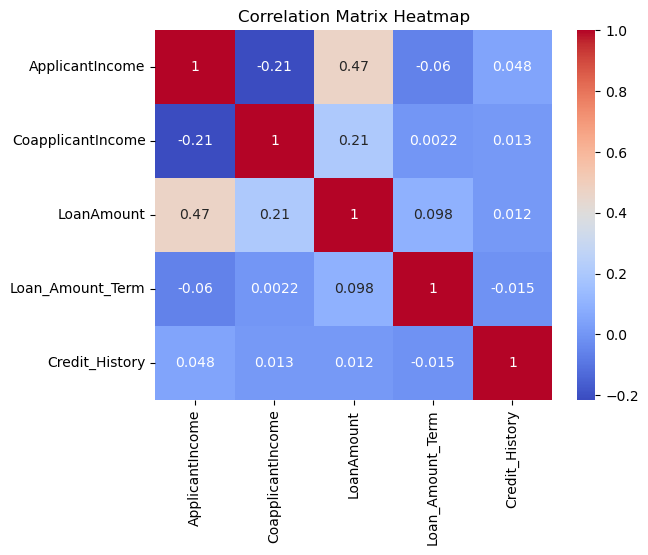

In [19]:
# Compute the correlation matrix ot understand which features are strongly correlated. Using Seaborn. 
corr_matrix = filtered_data_df.corr()

# Create a heatmap
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True)

# Set the title of the plot
plt.title('Correlation Matrix Heatmap')

# Show the plot
plt.show()


Number of people who take loan as group by Gender
Male      446
Female    101
Name: Gender, dtype: int64


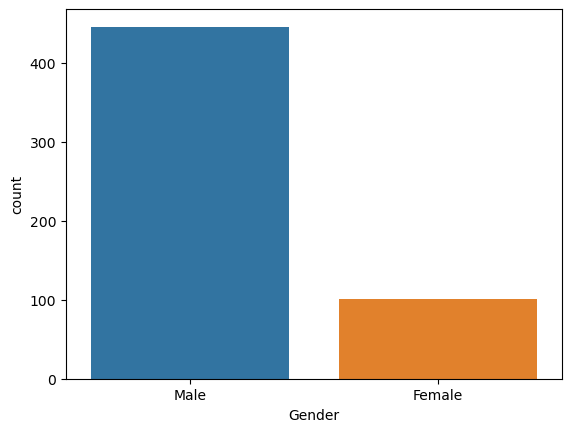

In [20]:
# think of doing a pie chart.....
print("Number of people who take loan as group by Gender")
print(filtered_data_df['Gender'].value_counts())
sns.countplot(x="Gender",data=filtered_data_df)
plt.show()

Number of people who take loan as group by marital Status
Yes    356
No     191
Name: Married, dtype: int64


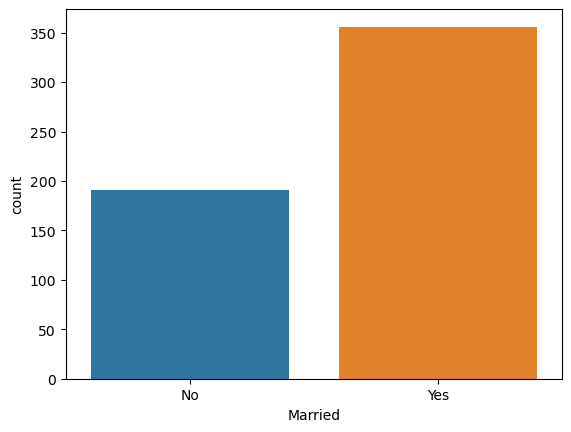

In [21]:
print("Number of people who take loan as group by marital Status")
print(filtered_data_df['Married'].value_counts())
sns.countplot(x="Married",data=filtered_data_df)
plt.show()

Number of people who take loan as group by Dependents
0     329
2      93
1      85
3+     40
Name: Dependents, dtype: int64


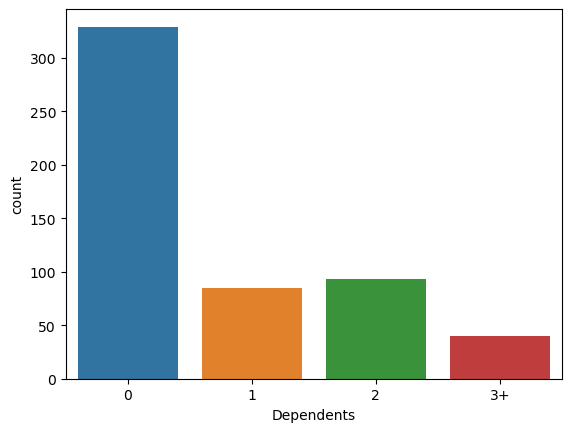

In [22]:
print("Number of people who take loan as group by Dependents")
print(filtered_data_df['Dependents'].value_counts())
sns.countplot(x="Dependents",data=filtered_data_df)
plt.show()

Number of people who take loan as group by Self_Employed
No     484
Yes     63
Name: Self_Employed, dtype: int64


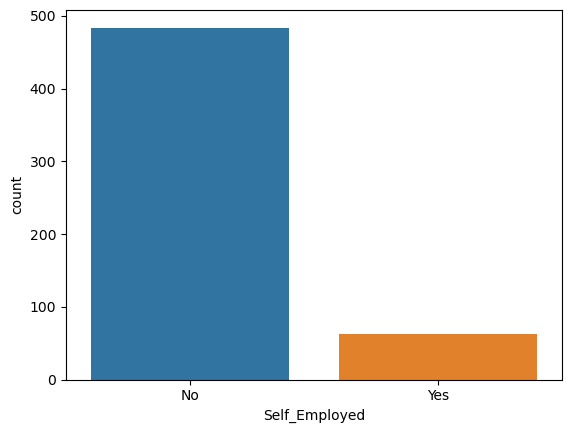

In [23]:
print("Number of people who take loan as group by Self_Employed")
print(filtered_data_df['Self_Employed'].value_counts())
sns.countplot(x="Self_Employed",data=filtered_data_df)
plt.show()

Number of people who take loan as group by Property_Area
Semiurban    209
Urban        176
Rural        162
Name: Property_Area, dtype: int64


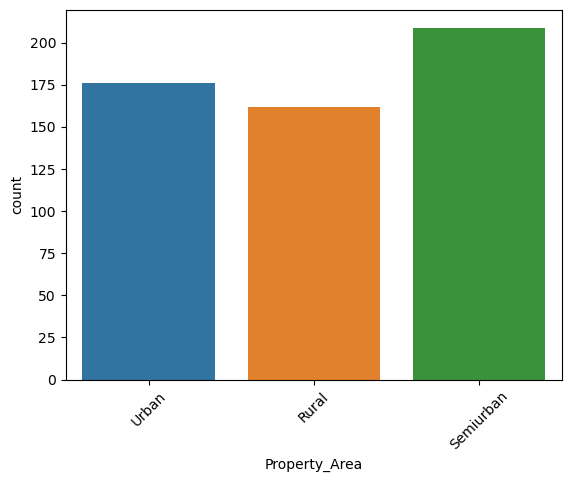

In [24]:
print("Number of people who take loan as group by Property_Area")
print(filtered_data_df['Property_Area'].value_counts())
sns.countplot(x="Property_Area",data=filtered_data_df)
plt.xticks(rotation=45)
plt.show()

Number of people who take loan as group by Education
Graduate        416
Not Graduate    131
Name: Education, dtype: int64


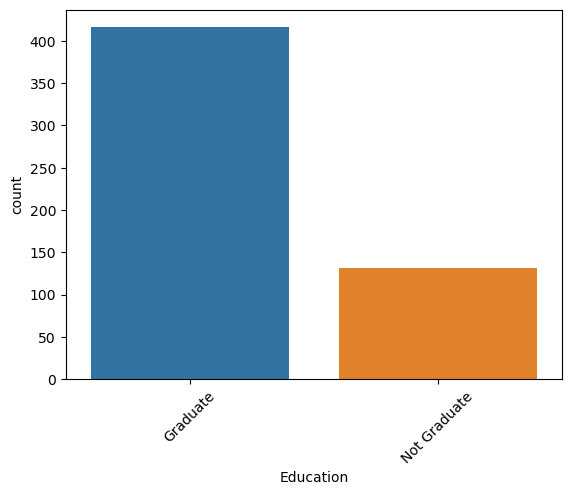

In [25]:
print("Number of people who take loan as group by Education")
print(filtered_data_df['Education'].value_counts())
sns.countplot(x="Education",data=filtered_data_df)
plt.xticks(rotation=45)
plt.show()

<Axes: xlabel='ApplicantIncome', ylabel='LoanAmount'>

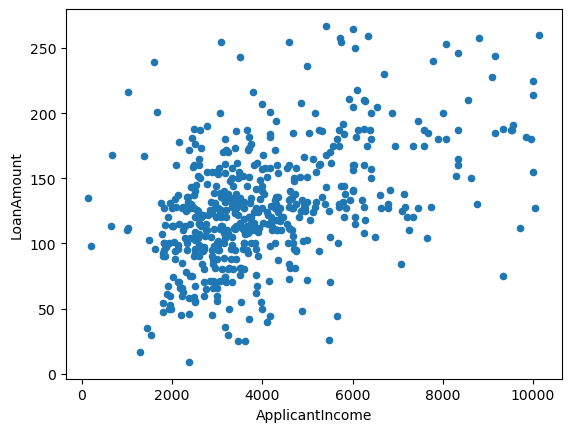

In [26]:
#scatter plot
filtered_data_df.plot.scatter(x='ApplicantIncome',y='LoanAmount')

# Splitting Dataset 

In [27]:
X = filtered_data_df.drop(['Loan_Status'],axis=1)
Y = filtered_data_df['Loan_Status']

In [28]:
#spliting train test data

X_train, X_test, Y_train, Y_test = train_test_split(X, Y,test_size=0.3,random_state=1)

X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((382, 11), (165, 11), (382,), (165,))

In [29]:


X_train

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
49,Female,No,0,Graduate,No,4000,2275.0,144.0,360.0,1.0,Semiurban
573,Male,Yes,2,Not Graduate,No,6125,1625.0,187.0,480.0,1.0,Semiurban
531,Male,Yes,3+,Graduate,No,4281,0.0,100.0,360.0,1.0,Urban
98,Male,Yes,0,Not Graduate,No,4188,0.0,115.0,180.0,1.0,Semiurban
501,Female,No,0,Graduate,No,3159,0.0,100.0,360.0,1.0,Semiurban
...,...,...,...,...,...,...,...,...,...,...,...
143,Male,Yes,0,Graduate,No,2698,2034.0,122.0,360.0,1.0,Semiurban
162,Male,Yes,1,Graduate,No,3089,1280.0,121.0,360.0,0.0,Semiurban
77,Male,Yes,1,Graduate,Yes,1000,3022.0,110.0,360.0,1.0,Urban
264,Male,No,0,Graduate,Yes,5166,0.0,128.0,360.0,1.0,Semiurban


In [30]:
Y_train

49     Y
573    N
531    Y
98     Y
501    Y
      ..
143    Y
162    N
77     N
264    Y
40     N
Name: Loan_Status, Length: 382, dtype: object

In [31]:
X_test

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
541,Female,No,0,Graduate,No,2138,0.0,99.000000,360.0,0.0,Semiurban
95,Male,No,0,Graduate,No,6782,0.0,127.396584,360.0,1.0,Urban
287,Male,Yes,0,Graduate,No,3704,2000.0,120.000000,360.0,1.0,Rural
360,Female,No,1,Graduate,No,4723,0.0,81.000000,360.0,1.0,Semiurban
548,Female,No,0,Graduate,No,5000,0.0,103.000000,360.0,0.0,Semiurban
...,...,...,...,...,...,...,...,...,...,...,...
387,Male,Yes,0,Not Graduate,No,3010,3136.0,127.396584,360.0,0.0,Urban
593,Male,Yes,0,Graduate,No,3859,3300.0,142.000000,180.0,1.0,Rural
611,Male,Yes,1,Graduate,No,8072,240.0,253.000000,360.0,1.0,Urban
262,Female,No,1,Graduate,No,3481,0.0,155.000000,36.0,1.0,Semiurban


In [32]:
Y_test

541    N
95     N
287    Y
360    N
548    N
      ..
387    N
593    Y
611    Y
262    N
85     Y
Name: Loan_Status, Length: 165, dtype: object

In [33]:
from sklearn.ensemble import RandomForestClassifier

feature_names = [f"feature {i}" for i in range(X.shape[1])]
forest = RandomForestClassifier(random_state=0)
forest.fit(X_train, Y_train)

ValueError: could not convert string to float: 'Female'

In [ ]:
import time
import numpy as np

start_time = time.time()
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

In [ ]:
# top features 5, 7, and 9 ( ApplicantIncome, LoanAmount, and Credit_History)
import pandas as pd

forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

## convert Categorical variable with Numerical values.

In [34]:
X_train.columns

Index(['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed',
       'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area'],
      dtype='object')

In [35]:
# Encoding categorical data
# Encoding the Independent Variable

columns = ['Gender','Married','Dependents','Education','Self_Employed']
labelencoder_X = LabelEncoder()
for i,col in enumerate(columns):
    
    X_train[col] = labelencoder_X.fit_transform(X_train.iloc[:,i])

X_train["Property_Area"] = labelencoder_X.fit_transform(X_train.iloc[:,10])

In [36]:
# Encoding the Dependent Variable
labelencoder_y = LabelEncoder()
Y_train = labelencoder_y.fit_transform(Y_train)

In [37]:
X_train

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
49,0,0,0,0,0,4000,2275.0,144.0,360.0,1.0,1
573,1,1,2,1,0,6125,1625.0,187.0,480.0,1.0,1
531,1,1,3,0,0,4281,0.0,100.0,360.0,1.0,2
98,1,1,0,1,0,4188,0.0,115.0,180.0,1.0,1
501,0,0,0,0,0,3159,0.0,100.0,360.0,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...
143,1,1,0,0,0,2698,2034.0,122.0,360.0,1.0,1
162,1,1,1,0,0,3089,1280.0,121.0,360.0,0.0,1
77,1,1,1,0,1,1000,3022.0,110.0,360.0,1.0,2
264,1,0,0,0,1,5166,0.0,128.0,360.0,1.0,1


In [38]:
Y_train

array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0,
       1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1,
       1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0,
       1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1,

In [39]:
# Encoding categorical data (testing data)
# Encoding the Independent Variable

labelencoder_X = LabelEncoder()

for i,col in enumerate(columns):
    X_test[col] = labelencoder_X.fit_transform(X_test.iloc[:,i])

X_test["Property_Area"] = labelencoder_X.fit_transform(X_test.iloc[:,10])
    
# Encoding the Dependent Variable
labelencoder_y = LabelEncoder()
Y_test = labelencoder_y.fit_transform(Y_test)

In [40]:
X_test

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
541,0,0,0,0,0,2138,0.0,99.000000,360.0,0.0,1
95,1,0,0,0,0,6782,0.0,127.396584,360.0,1.0,2
287,1,1,0,0,0,3704,2000.0,120.000000,360.0,1.0,0
360,0,0,1,0,0,4723,0.0,81.000000,360.0,1.0,1
548,0,0,0,0,0,5000,0.0,103.000000,360.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...
387,1,1,0,1,0,3010,3136.0,127.396584,360.0,0.0,2
593,1,1,0,0,0,3859,3300.0,142.000000,180.0,1.0,0
611,1,1,1,0,0,8072,240.0,253.000000,360.0,1.0,2
262,0,0,1,0,0,3481,0.0,155.000000,36.0,1.0,1


In [41]:
Y_test

array([0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0,
       1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1,
       0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1,
       0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1,
       1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1])

In [42]:
# Feature Scaling

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

# Model Training and Evaluation

In [43]:


def model_report(models,X_train,X_test,y_train,y_test):
    for name, model in models:
        model.fit(X_train, y_train)
        y_hat_train = model.predict(X_train)
        y_hat_test  = model.predict(X_test)
        print("_"*80)
        print(f"Report For {name}".center(80))
        print()
        print(f"Training Accuracy: {accuracy_score(y_train, y_hat_train):.2f}")
        print(f"Test     Accuracy: {accuracy_score(y_test, y_hat_test):.2f}")
        print()
        #print(f"Training Accuracy: {confusion_matrix(y_train, y_hat_train)}")
        print(f"Test     Accuracy: {confusion_matrix(y_test, y_hat_test)}")
        print()
        print(f"Training Accuracy: {classification_report(y_train, y_hat_train)}")
        print(f"Test     Accuracy: {classification_report(y_test, y_hat_test)}")
        print('\n\n')

In [44]:
#Preparing different models--- first iteration... choose best model from these models. Default config
  
knn = KNeighborsClassifier()
rfc = RandomForestClassifier()
svc = SVC()
lc = LogisticRegression()
classifier = GaussianNB()
dt = DecisionTreeClassifier() 


model = [
    ('LogisticRegression',lc),
    ('KNeighborsClassifier',knn),
    ('svc',svc),
    ('RandomForestClassifier',rfc),
    ('GaussianNB',classifier),
    ('DecisionTreeClassifier',dt)
]

In [45]:
model_report(model,X_train,X_test,Y_train,Y_test)

________________________________________________________________________________
                         Report For LogisticRegression                          

Training Accuracy: 0.83
Test     Accuracy: 0.79

Test     Accuracy: [[ 23  31]
 [  3 108]]

Training Accuracy:               precision    recall  f1-score   support

           0       0.94      0.45      0.61       114
           1       0.81      0.99      0.89       268

    accuracy                           0.83       382
   macro avg       0.88      0.72      0.75       382
weighted avg       0.85      0.83      0.81       382

Test     Accuracy:               precision    recall  f1-score   support

           0       0.88      0.43      0.57        54
           1       0.78      0.97      0.86       111

    accuracy                           0.79       165
   macro avg       0.83      0.70      0.72       165
weighted avg       0.81      0.79      0.77       165




__________________________________________________

## Model Optimization 

In [46]:
from sklearn.model_selection import GridSearchCV

In [47]:
# dictionary with different parameters to test what is best for the model.
# chose random forest to dig deeper/optimize
param_grid = {
'n_estimators': [25, 50, 100, 150],
'max_features': ['sqrt', 'log2', None],
'max_depth': [3, 6, 9],
'max_leaf_nodes': [3, 6, 9],
}


forest = RandomForestClassifier(n_jobs=-1)

grid_search = GridSearchCV(forest, param_grid, cv=5,
                      scoring="accuracy", return_train_score=True)



In [48]:
grid_search.fit(X_train, Y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(n_jobs=-1),
             param_grid={'max_depth': [3, 6, 9],
                         'max_features': ['sqrt', 'log2', None],
                         'max_leaf_nodes': [3, 6, 9],
                         'n_estimators': [25, 50, 100, 150]},
             return_train_score=True, scoring='accuracy')

In [49]:
best_model = grid_search.best_estimator_

In [50]:
best_parameters = grid_search.best_params_
print(best_parameters)

{'max_depth': 3, 'max_features': 'sqrt', 'max_leaf_nodes': 3, 'n_estimators': 100}


In [51]:
best_parameters = grid_search.best_params_
print(best_parameters)

{'max_depth': 3, 'max_features': 'sqrt', 'max_leaf_nodes': 3, 'n_estimators': 100}


In [52]:
result = grid_search.cv_results_

In [53]:
print(list(result.keys()))

['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_max_depth', 'param_max_features', 'param_max_leaf_nodes', 'param_n_estimators', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score', 'split0_train_score', 'split1_train_score', 'split2_train_score', 'split3_train_score', 'split4_train_score', 'mean_train_score', 'std_train_score']


In [54]:

train_scores = result['mean_train_score']
test_scores  = result['mean_test_score']
parameters = result['params']


scores = [ (tr, ts, pr) for tr, ts, pr in zip(train_scores, test_scores, parameters) ]


strformat = "|{:<5}|{:^20}| {:^20}| {}|\n{}\n"
lb =  '_'*110
print(strformat.format("", "Training Score", "Test Score", "Parameters", lb))
for ix, (tr, ts, pr) in enumerate(scores):
    print(strformat.format(ix+1, tr, ts, pr, lb))
    



|     |   Training Score   |      Test Score     | Parameters|
______________________________________________________________________________________________________________

|1    | 0.8259209257473481 |  0.8167464114832537 | {'max_depth': 3, 'max_features': 'sqrt', 'max_leaf_nodes': 3, 'n_estimators': 25}|
______________________________________________________________________________________________________________

|2    | 0.8206943105110897 |  0.8088174982911825 | {'max_depth': 3, 'max_features': 'sqrt', 'max_leaf_nodes': 3, 'n_estimators': 50}|
______________________________________________________________________________________________________________

|3    | 0.8278817100610736 |  0.8272385509227614 | {'max_depth': 3, 'max_features': 'sqrt', 'max_leaf_nodes': 3, 'n_estimators': 100}|
______________________________________________________________________________________________________________

|4    | 0.8272259723561556 |  0.8272385509227614 | {'max_depth': 3, 'max_features': 's

In [55]:
scores.sort(key=lambda x: x[1],reverse=True)

print("Top 10 Models")
strformat = "|{:<5}|{:^20}| {:^20}| {}|\n{}\n"
lb =  '_'*110
print(strformat.format("", "Training Score", "Test Score", "Parameters", lb))
for ix, (tr, ts, pr) in enumerate(scores[:10]):
    print(strformat.format(ix+1, tr, ts, pr, lb))
    

Top 10 Models
|     |   Training Score   |      Test Score     | Parameters|
______________________________________________________________________________________________________________

|1    | 0.8278817100610736 |  0.8272385509227614 | {'max_depth': 3, 'max_features': 'sqrt', 'max_leaf_nodes': 3, 'n_estimators': 100}|
______________________________________________________________________________________________________________

|2    | 0.8272259723561556 |  0.8272385509227614 | {'max_depth': 3, 'max_features': 'sqrt', 'max_leaf_nodes': 3, 'n_estimators': 150}|
______________________________________________________________________________________________________________

|3    | 0.8278817100610736 |  0.8272385509227614 | {'max_depth': 3, 'max_features': 'sqrt', 'max_leaf_nodes': 6, 'n_estimators': 25}|
______________________________________________________________________________________________________________

|4    | 0.8285353048323154 |  0.8272385509227614 | {'max_depth': 3, 'ma

### Final best value

In [56]:
rfc = RandomForestClassifier(n_jobs=-1,max_depth= 3, max_features= 'sqrt', max_leaf_nodes= 9, n_estimators= 25)

In [57]:
model_report([("RandomForestClassifier",rfc)],X_train,X_test,Y_train,Y_test)

________________________________________________________________________________
                       Report For RandomForestClassifier                        

Training Accuracy: 0.83
Test     Accuracy: 0.79

Test     Accuracy: [[ 23  31]
 [  3 108]]

Training Accuracy:               precision    recall  f1-score   support

           0       0.94      0.45      0.61       114
           1       0.81      0.99      0.89       268

    accuracy                           0.83       382
   macro avg       0.88      0.72      0.75       382
weighted avg       0.85      0.83      0.81       382

Test     Accuracy:               precision    recall  f1-score   support

           0       0.88      0.43      0.57        54
           1       0.78      0.97      0.86       111

    accuracy                           0.79       165
   macro avg       0.83      0.70      0.72       165
weighted avg       0.81      0.79      0.77       165




